<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DL_MovieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries/Dataset

Import Libraries

In [34]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd
from sklearn.model_selection import train_test_split

from tensorflow import keras

from matplotlib import pyplot as plt

In [30]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

Import Dataset

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
df= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset/IMDB Dataset.csv')

In [10]:
df.shape

(50000, 2)

In [24]:
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Check GPU

In [15]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

get_available_gpus()

['/device:GPU:0']

### Data Visualization

In [19]:
for i,r in df[:2].iterrows():
  print('*'*50)
  print("Review:",r['review'],"\n")
  print("Sentiment:",r['sentiment'],"\n")
  

**************************************************
Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br 

In [25]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

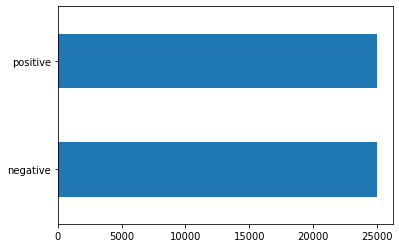

In [23]:
df['sentiment'].value_counts().plot(kind='barh')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.20, random_state=2020)
print('Train Features shape:',X_train.shape)
print('Test Features shape:',X_test.shape)
print('Train label shape:',y_train.shape)
print('Test label shape:',y_test.shape)

Train Features shape: (40000,)
Test Features shape: (10000,)
Train label shape: (40000,)
Test label shape: (10000,)
